In [33]:
from google.colab import files
uploaded = files.upload()

Saving right2.jpg to right2.jpg
time: 15.8 s


In [2]:
!ls

sample_data  uch006a.jpg


In [3]:
!pip install ipython-autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1831 sha256=61beae98024d115874a4545de0107e5b467ba1daea281d5da7628cb7a3d40c4f
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [4]:
%load_ext autotime

In [5]:
!pip install -U opencv-python

     |████████████████████████████████| 49.5MB 82kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
time: 10.5 s


**Parte 2**

In [6]:
%load_ext Cython

time: 460 ms


In [10]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef float[:, :] gradx(float [:, :] input):
  # POR HACER: calcular el gradiente en x
  cdef np.ndarray output=np.zeros([input.shape[0], input.shape[1]], dtype = np.float32)

  return output

time: 3.22 ms


In [11]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef float[:, :] grady(float [:, :] input):
  # POR HACER: Calcular el gradiente en y
  cdef np.ndarray output=np.zeros([input.shape[0], input.shape[1]], dtype = np.float32)

  return output

time: 2.61 ms


In [12]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef float[:, :] product(float [:, :] input1, float [:, :] input2):
  # POR HACER: generar una matriz que contenga el producto entre input1 e input2, pixel a pixel

  cdef np.ndarray output=np.zeros([input1.shape[0], input1.shape[1]], dtype = np.float32)
  return output

time: 4.35 s


In [13]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef float[:, :] harris(float [:, :] mxx, float [:, :] mxy, float [:, :] myy):
  # POR HACER: Calcular el filtro de Harris a partir de (mxx, mxy, myy)
  cdef np.ndarray output=np.zeros([mxx.shape[0], mxx.shape[1]], dtype = np.float32)

  return output

time: 4.51 s


In [14]:
%%cython
import cython
import numpy as np
cimport numpy as np
from libc.math cimport sqrt

cpdef float[:, :] shiTomasi(float [:, :] mxx, float [:, :] mxy, float [:, :] myy):
  # POR HACER: Calcular el filtro de Shi-Tomasi a partir de (mxx, mxy, myy)
  cdef np.ndarray output=np.zeros([mxx.shape[0], mxx.shape[1]], dtype = np.float32)

  return output

time: 4.35 s


In [15]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef float[:, :] getMaxima(float [:, :] h, float val):
  # POR HACER: Crear una imagen, inicialmente llena con ceros.
  # Luego, hacer 1 los valores en los cuales:
  #   h[r,c] sea un maximo local respecto a sus 8 vecinos
  #   h[r,c] supera el valor val
  cdef np.ndarray output=np.zeros([h.shape[0], h.shape[1]], dtype = np.float32)

  return output

time: 4.52 s


In [16]:
# Esta funcion genera keypoints a partir de una imagen de entrada
# La imagen de entrada puede ser la salida del filtro de Harris o el de Shi-Tomasi
# No es necesario modificar esta funcion
def getKeyPoints(input):
  output = []
  input_rows = input.shape[0]
  input_cols = input.shape[1]
  for r in range(input_rows):
    for c in range(input_cols):
      if input[r,c] > 0:
        kp = cv2.KeyPoint()
        kp.pt = (c,r)
        kp.size = 10
        kp.angle = 0
        output.append(kp)
  return output

time: 8.35 ms


In [17]:
def harrisDetector(input, val):
  input = np.float32( input )
  # Por hacer: calcular el filtro de Harris
  # Hay que realizar los siguientes pasos:
  # 1) Suavizar la imagen de entrada con cv.GaussianBlur( )
  # 2) Calcular gradientes imx e imy (usando funciones de cython definidas arriba)
  # 3) Calcular momentos usando la funcion product( )
  #    imxx = imx*imx (pixel a pixel)
  #    imxy = imx*imy (pixel a pixel)
  #    imyy = imy*imy (pixel a pixel)
  # 4) Suavizar momentos imxx, imxy, imyy con cv.GaussianBlur( )
  #    => Puede requerir transformar las imagenes de Cython a Python usando np.float32( )
  # 5) Aplicar el filtro de Harris (usando funcion de Cython definida arriba)
  # 6) Encontrar puntos maximos usando getMaxima( )
  # 7) Generar el listado de puntos usando getKeyPoints( )
  # 8) Devolver los puntos e interes y la imagen filtrada

  h = input    # Esta linea debe ser eliminada
  points = []  # Esta linea debe ser eliminada
  return points, np.float32(h)

time: 3.52 ms


In [18]:
def shiTomasiDetector(input, val):
  input = np.float32( input )
  # Por hacer: calcular el filtro de Shi-Tomasi
  # El procedimiento es similar al de la funcion de arriba
  # Sin embargo, se debe llamar al filtro de Shi-Tomasi en vez del de Harris

  h = input    # Esta linea debe ser eliminada
  points = []  # Esta linea debe ser eliminada
  return points, np.float32(h)
  return points, np.float32(h)

time: 7.43 ms


In [29]:
def do_rotate(img, angle):
  h = img.shape[0]
  w = img.shape[1]
  cx = w // 2
  cy = h // 2
  m = cv2.getRotationMatrix2D((cx, cy), -angle, 1.0)
  cosa = np.cos(angle * np.pi / 180.0)
  sina = np.sin(angle * np.pi / 180.0)
  nw = int((h * sina) + (w * cosa))
  nh = int((h * cosa) + (w * sina))
  m[0,2] += (nw / 2) - cx
  m[1,2] += (nh / 2) - cy
  return cv2.warpAffine(img, m, (nw, nh))

time: 5.17 ms


Resultados de filtro de Harris


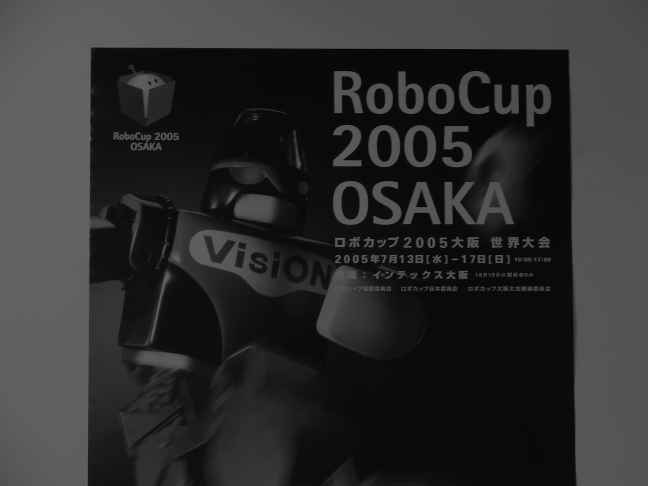

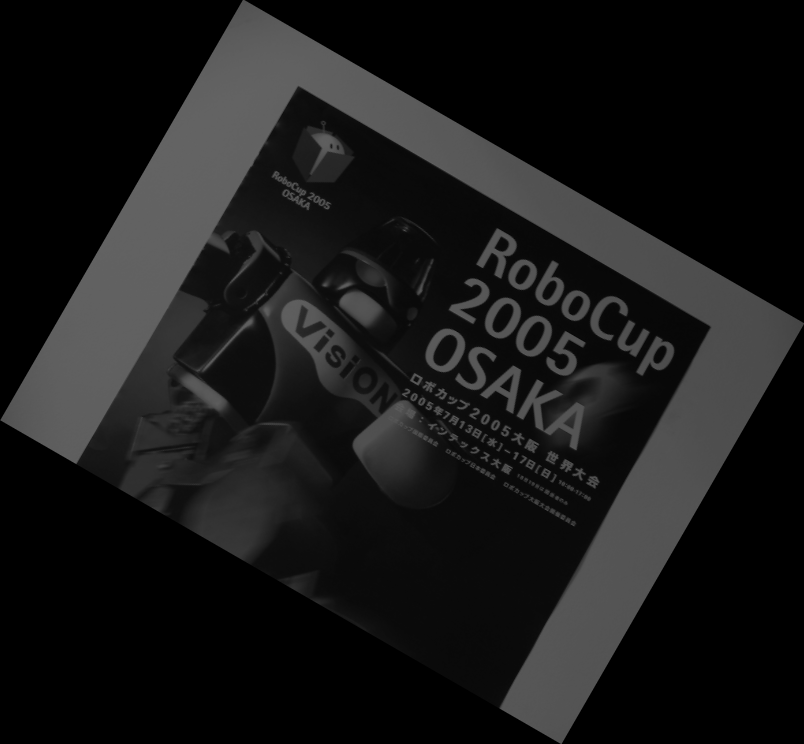

Puntos de interes


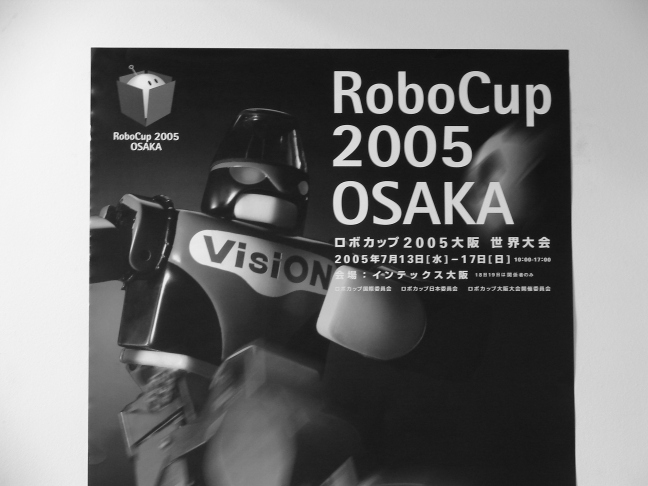

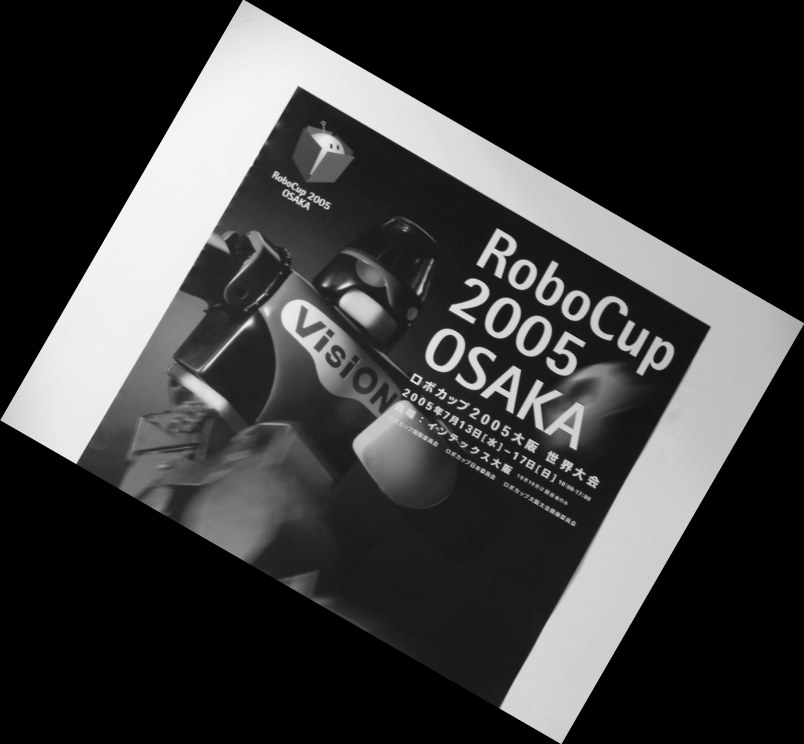

time: 381 ms


In [30]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img1 = cv2.imread('uch006a.jpg',0)
img2 = do_rotate(img1, 30)

kp1, h1 = harrisDetector(img1, 3e7)
kp2, h2 = harrisDetector(img2, 3e7)

res1 = cv2.drawKeypoints(img1, kp1, img1, None, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
res2 = cv2.drawKeypoints(img2, kp2, img2, None, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print('Resultados de filtro de Harris')
cv2_imshow(h1 * 100 / np.max(np.max(h1)))
cv2_imshow(h2 * 100 / np.max(np.max(h2)))
print('Puntos de interes')
cv2_imshow(res1)
cv2_imshow(res2)


**Parte 3**

In [37]:
# Esta funcion ya esta lista, no debe ser modificada
def filterMatches(matches):
  # Apply ratio test
  points1 = []
  points2 = []
  good = []

  for m,n in matches:
    if m.distance < 0.75*n.distance:  # 0.75
      good.append([m])
      points1.append(kp1[m.queryIdx].pt)
      points2.append(kp2[m.trainIdx].pt)
  return np.array(points1), np.array(points2), good

time: 9.19 ms


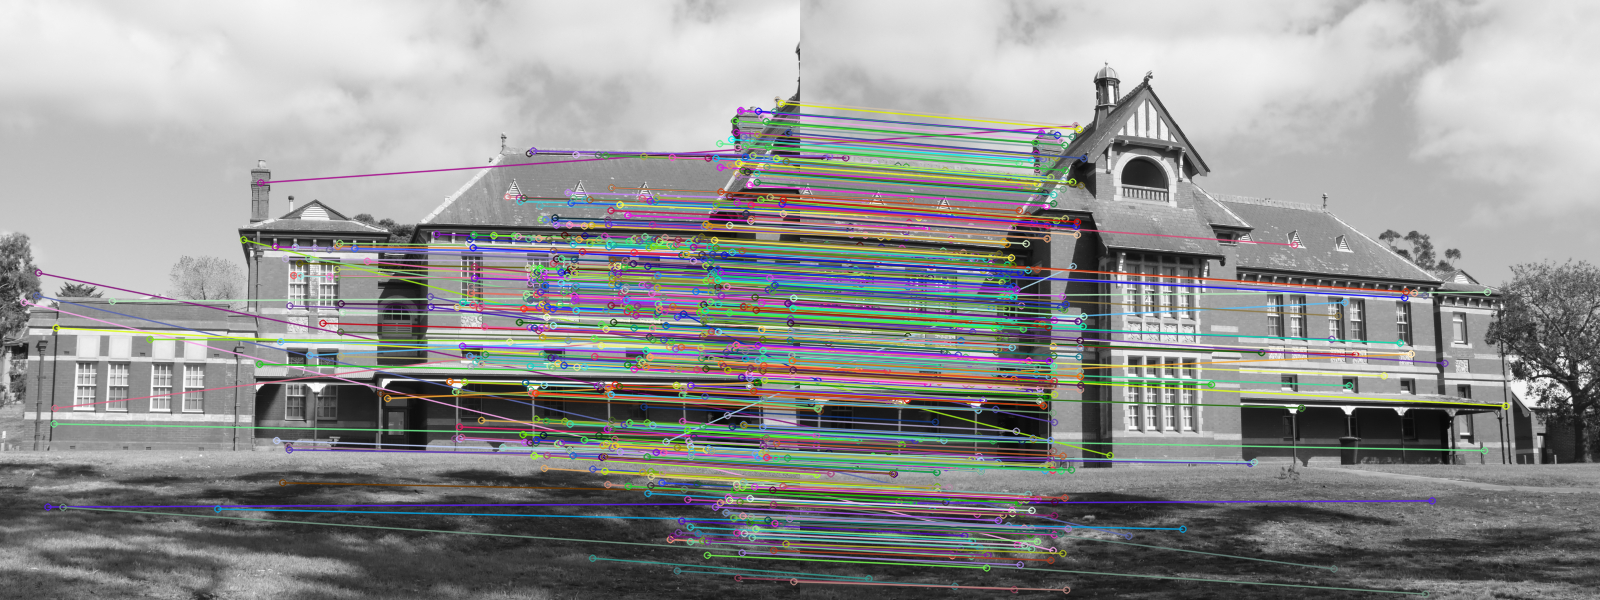

time: 1.15 s


In [41]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img1 = cv2.imread('left2.jpg',0)
img2 = cv2.imread('right2.jpg',0)

detector = cv2.SIFT_create()

(kp1, des1) = detector.detectAndCompute(img1,None)
(kp2, des2) = detector.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

points1, points2, good = filterMatches(matches)

img_match = cv2.drawMatchesKnn(img1, kp1, img2, kp2,
                                good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2_imshow(img_match)

# El objetivo del codigo que sigue es alinear dos imagenes

# 1) Por hacer: calcular la homografia usando cv2.findHomography( ) con parametro cv2.RANSAC

# 2) Por hacer: transformar la imagen img2 usando la funcion warpPerspective( ) y la homografia
#   La imagen de salida debe tener un tamano suficiente
#   Se recomienda que tenga el doble del ancho de la imagen de entrada

# 3) Por hacer: copiar la imagen img1 a la imagen resultante del paso anterior (se obtiene la imagen fusionada)

# 4) Por hacer: mostrar la imagen fusionada